INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_zprw6tw/16_ykmjx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_zprw6tw/eonndl6r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87363', 'data', 'file=/tmp/tmp_zprw6tw/16_ykmjx.json', 'init=/tmp/tmp_zprw6tw/eonndl6r.json', 'output', 'file=/tmp/tmp_zprw6tw/prophet_modelcxgi8k4p/prophet_model-20231121210447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:04:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:04:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


31/31 [==============================] - 0s 2ms/step


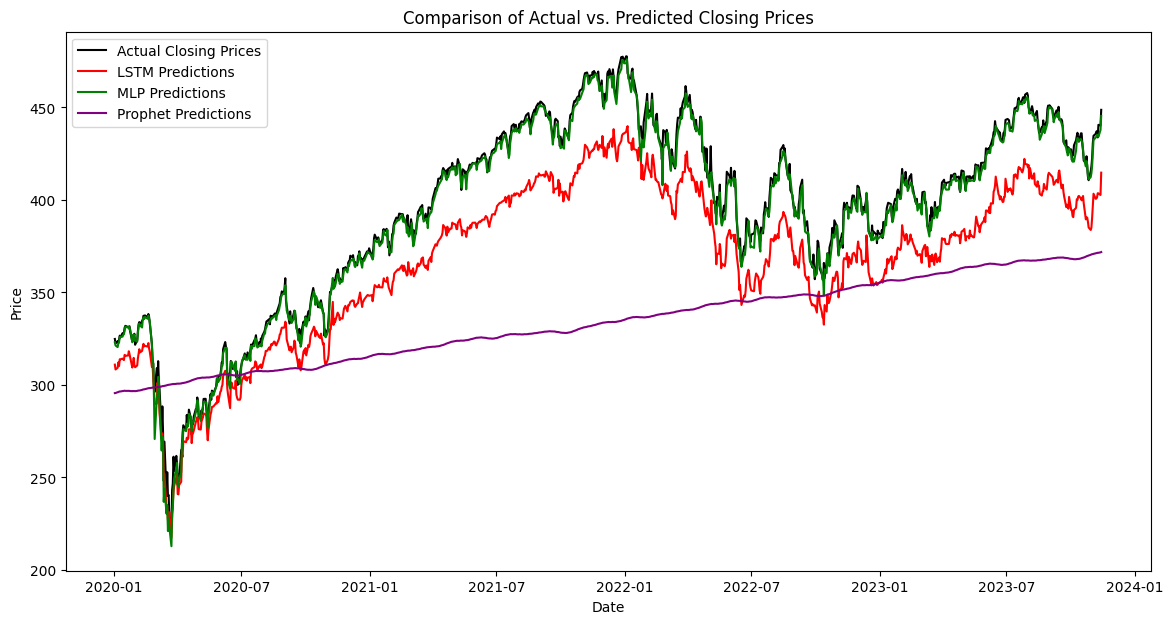

In [ ]:
import pandas as pd
from prophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler

#Reading in the data
df = pd.read_csv('SPYhist.csv')

#Fixing any dat time errors
df['Date'] = pd.to_datetime(df['Date'])

#Cleaning data for Prophet
df_prophet = df[['Date', 'Close']]
df_prophet = df_prophet.rename(columns={'Date': 'ds', 'Close': 'y'})

#Put the data into train, validation, and test by date
train_prophet = df_prophet[df_prophet['ds'] < '2019-01-01']
val_prophet = df_prophet[(df_prophet['ds'] >= '2019-01-01') & (df_prophet['ds'] < '2020-01-01')]
test_prophet = df_prophet[df_prophet['ds'] >= '2020-01-01']

#Configuring the Prophet model
model_prophet = Prophet()
model_prophet.fit(train_prophet)

#Getting features for training
X = df[['Volume', 'Open', 'Low']].values
y = df['Close'].values

#Scaling all the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Chnaging shape for LSTM
X_lstm = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

#Put the data into train, validation, and test
train_size = train_prophet.shape[0]
val_size = val_prophet.shape[0]

X_train_lstm = X_lstm[:train_size]
y_train = y[:train_size]
X_val_lstm = X_lstm[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]
X_test_lstm = X_lstm[train_size + val_size:]
y_test = y[train_size + val_size:]

#Configuring the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(1, X_scaled.shape[1])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_lstm, y_train, validation_data=(X_val_lstm, y_val), epochs=50, batch_size=64, verbose=0)

#Configuring the MLP Model
mlp_model = Sequential()
mlp_model.add(Dense(50, activation='relu', input_dim=X_scaled.shape[1]))
mlp_model.add(Dense(1))
mlp_model.compile(optimizer='adam', loss='mean_squared_error')
X_train_mlp = X_scaled[:train_size]
X_val_mlp = X_scaled[train_size:train_size + val_size]
X_test_mlp = X_scaled[train_size + val_size:]
mlp_model.fit(X_train_mlp, y_train, validation_data=(X_val_mlp, y_val), epochs=50, batch_size=64, verbose=0)

#LSTM & MLP Predictions
lstm_predictions = lstm_model.predict(X_test_lstm).flatten()
mlp_predictions = mlp_model.predict(X_test_mlp).flatten()

#Prophet Predictions
future = test_prophet[['ds']]
forecast_prophet = model_prophet.predict(future)

#Plotting actuals vs predicted prices for all
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(test_prophet['ds'], y_test, label='Actual Closing Prices', color='black')
plt.plot(test_prophet['ds'], lstm_predictions, label='LSTM Predictions', color='red')
plt.plot(test_prophet['ds'], mlp_predictions, label='MLP Predictions', color='green')
plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], label='Prophet Predictions', color='purple')
plt.title('Comparison of Actual vs. Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


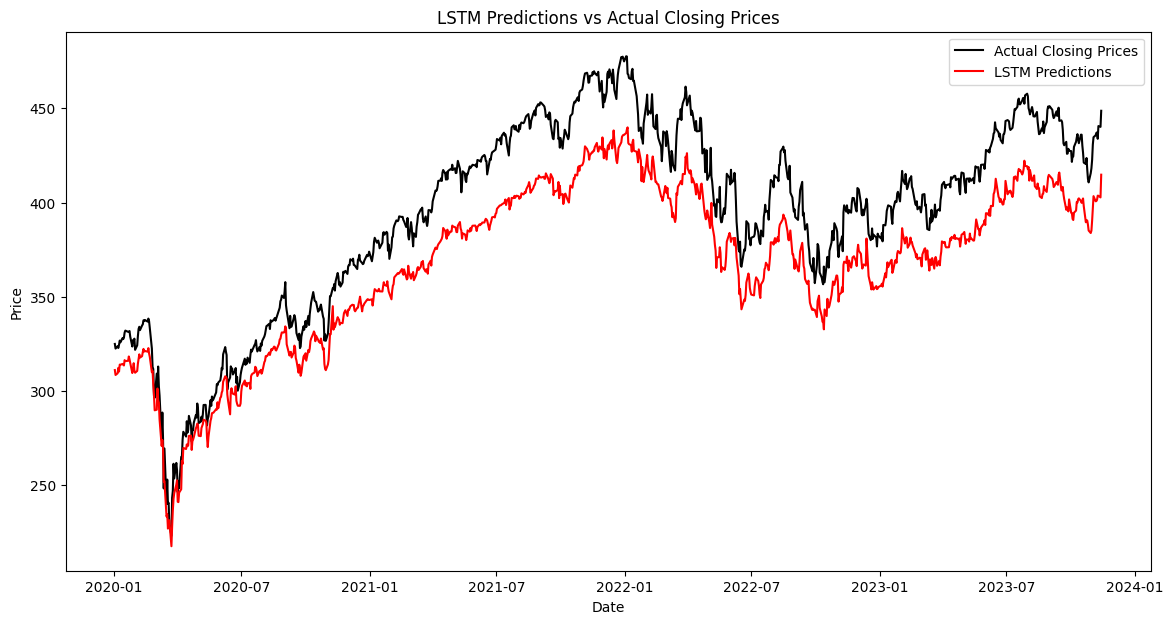

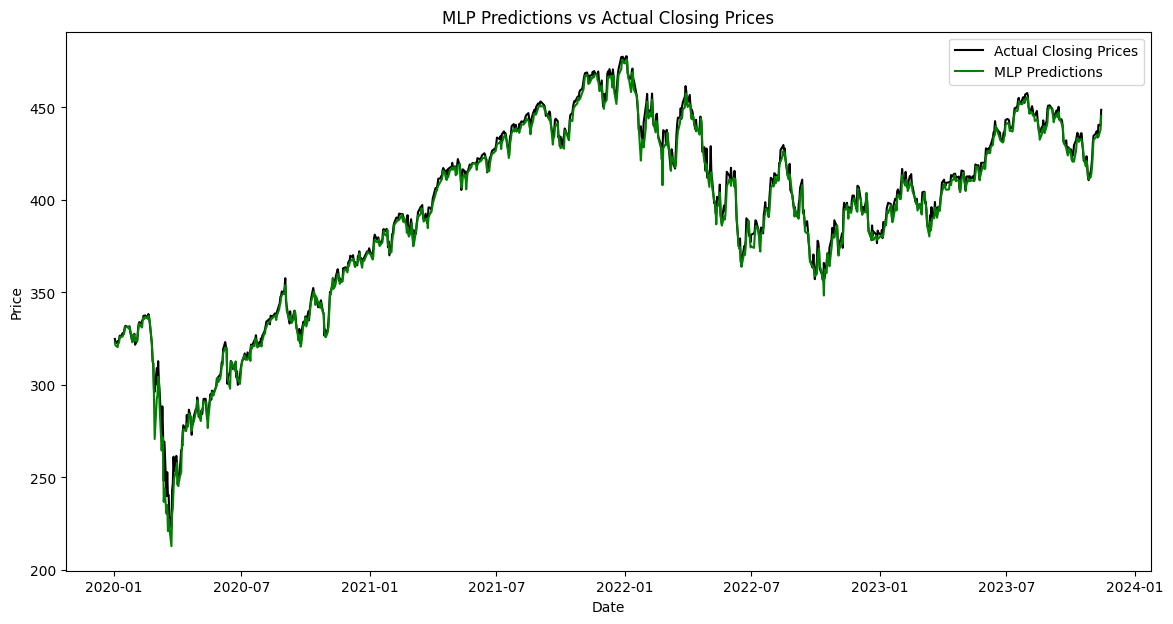

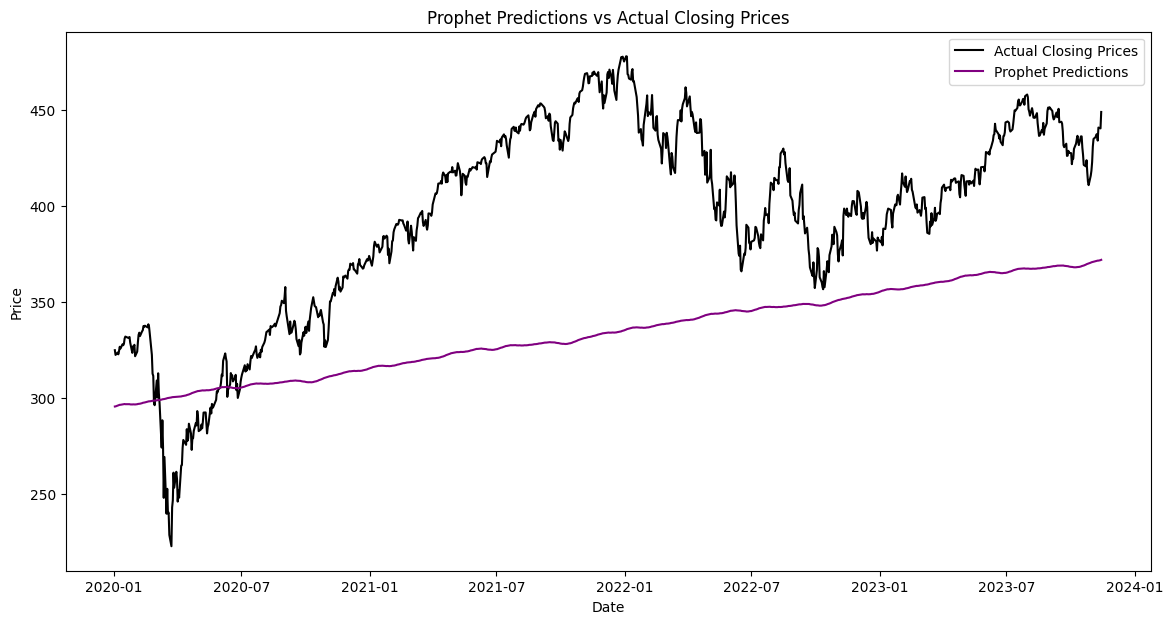

In [ ]:
#Plotting actuals vs predicted prices for LSTM
plt.figure(figsize=(14, 7))
plt.plot(test_prophet['ds'], y_test, label='Actual Closing Prices', color='black')
plt.plot(test_prophet['ds'], lstm_predictions, label='LSTM Predictions', color='red')
plt.title('LSTM Predictions vs Actual Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

#Plotting actuals vs predicted prices for MLP
plt.figure(figsize=(14, 7))
plt.plot(test_prophet['ds'], y_test, label='Actual Closing Prices', color='black')
plt.plot(test_prophet['ds'], mlp_predictions, label='MLP Predictions', color='green')
plt.title('MLP Predictions vs Actual Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

#Plotting actuals vs predicted prices for Prophet
plt.figure(figsize=(14, 7))
plt.plot(test_prophet['ds'], y_test, label='Actual Closing Prices', color='black')
plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], label='Prophet Predictions', color='purple')
plt.title('Prophet Predictions vs Actual Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

#Metrics for LSTM
lstm_mae = mean_absolute_error(y_test, lstm_predictions)
lstm_mse = mean_squared_error(y_test, lstm_predictions)
lstm_rmse = mean_squared_error(y_test, lstm_predictions, squared=False)

#Metrics for MLP
mlp_mae = mean_absolute_error(y_test, mlp_predictions)
mlp_mse = mean_squared_error(y_test, mlp_predictions)
mlp_rmse = mean_squared_error(y_test, mlp_predictions, squared=False)

#Metrics for Prophet
prophet_test_predictions = forecast_prophet[forecast_prophet['ds'].isin(test_prophet['ds'])]['yhat'].values
prophet_mae = mean_absolute_error(y_test, prophet_test_predictions)
prophet_mse = mean_squared_error(y_test, prophet_test_predictions)
prophet_rmse = mean_squared_error(y_test, prophet_test_predictions, squared=False)

#Data showing all together
performance_metrics = pd.DataFrame({
    'Model': ['LSTM', 'MLP', 'Prophet'],
    'MAE': [lstm_mae, mlp_mae, prophet_mae],
    'MSE': [lstm_mse, mlp_mse, prophet_mse],
    'RMSE': [lstm_rmse, mlp_rmse, prophet_rmse]
})

performance_metrics


,Model,MAE,MSE,RMSE
0,LSTM,26.638560,795.566467,28.205788
1,MLP,2.806854,16.014465,4.001808
2,Prophet,62.953951,5202.220225,72.126418


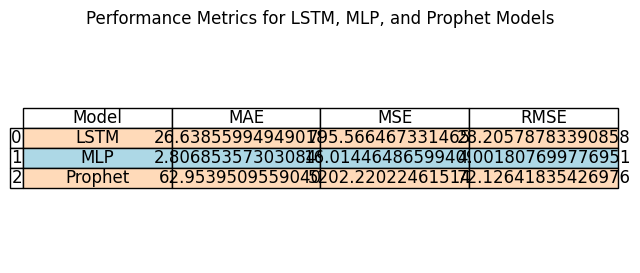

In [ ]:
import matplotlib.pyplot as plt
from pandas.plotting import table


fig, ax = plt.subplots(figsize=(8, 3))
ax.axis('tight')
ax.axis('off')

#Create table to show metrics
the_table = table(ax, performance_metrics, loc='center', cellLoc='center', colWidths=[0.2]*len(performance_metrics.columns))

the_table.auto_set_font_size(False)
the_table.set_fontsize(12)
the_table.scale(1.2, 1.2)
for (i, j), val in np.ndenumerate(performance_metrics.values):
    the_table[i+1, j].set_facecolor('#FFDAB9' if i % 2 == 0 else 'lightblue')

plt.title('Performance Metrics for LSTM, MLP, and Prophet Models')

plt.show()
